# Solution 2: Evaluating a decision tree

This notebook is a solution to the problem posed in [exercises/exercise-2.ipynb](../exercises/exercise-2.ipynb).

Don't peek at this until you've tried to solve it!

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.tree
import matplotlib
import matplotlib.pyplot as plt

In [18]:
X1, y1 = sklearn.datasets.make_gaussian_quantiles(
    cov=2.0, n_samples=500, n_features=2, n_classes=2, random_state=1
)
X2, y2 = sklearn.datasets.make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=1000, n_features=2, n_classes=2, random_state=1
)

X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

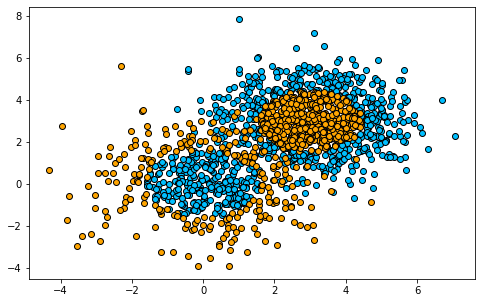

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black");
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black");

In [90]:
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=5)

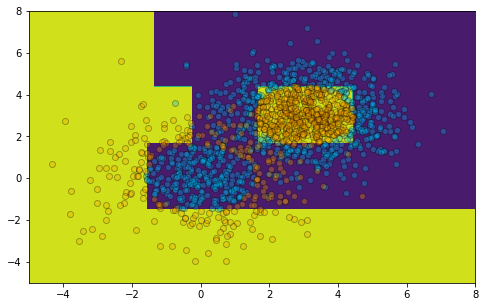

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))
Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

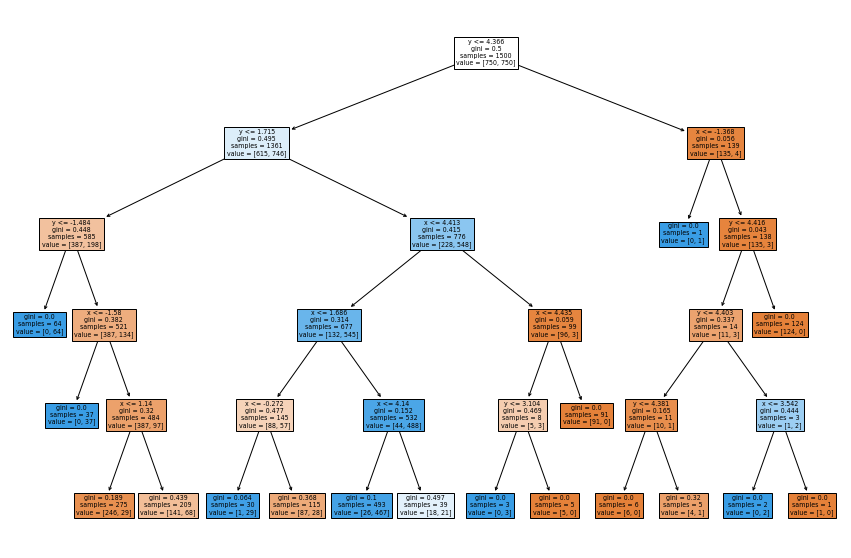

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sklearn.tree.plot_tree(decision_tree, feature_names=["x", "y"], filled=True, ax=ax);

In [112]:
def print_tree(tree, array_index=0, indent="", feature_names=["x", "y"]):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        yield f"{indent}{feature_names[feature]} <= {threshold:.2f}"
        yield from print_tree(tree, left_index, indent + "    ", feature_names)

        yield f"{indent}{feature_names[feature]} > {threshold:.2f}"
        yield from print_tree(tree, right_index, indent + "    ", feature_names)

    else:
        winner = np.argmax(tree.value[array_index])

        yield f"{indent}class: {winner}"

In [113]:
for mine, theirs in zip(
    print_tree(decision_tree.tree_),
    sklearn.tree.export_text(decision_tree, feature_names=["x", "y"]).split("\n"),
):
    print(f"{mine:40s} {theirs:40s}")

y <= 4.37                                |--- y <= 4.37                          
    y <= 1.72                            |   |--- y <= 1.72                      
        y <= -1.48                       |   |   |--- y <= -1.48                 
            class: 1                     |   |   |   |--- class: 1               
        y > -1.48                        |   |   |--- y >  -1.48                 
            x <= -1.58                   |   |   |   |--- x <= -1.58             
                class: 1                 |   |   |   |   |--- class: 1           
            x > -1.58                    |   |   |   |--- x >  -1.58             
                x <= 1.14                |   |   |   |   |--- x <= 1.14          
                    class: 0             |   |   |   |   |   |--- class: 0       
                x > 1.14                 |   |   |   |   |--- x >  1.14          
                    class: 0             |   |   |   |   |   |--- class: 0       
    y > 1.72    

In [116]:
decision_tree.predict([[0, 0]])

array([0])

In [130]:
def predict_single(position, tree, array_index=0):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        if position[feature] <= threshold:
            return predict_single(position, tree, left_index)
        else:
            return predict_single(position, tree, right_index)

    else:
        return np.argmax(tree.value[array_index], axis=1)

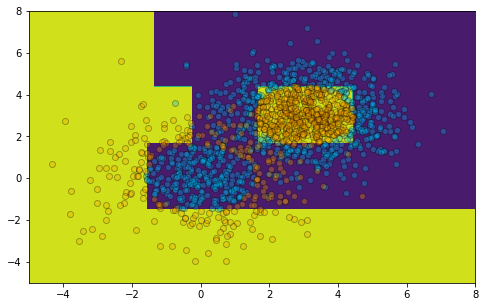

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    [predict_single(position, decision_tree.tree_) for position in np.c_[xx.ravel(), yy.ravel()]]
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

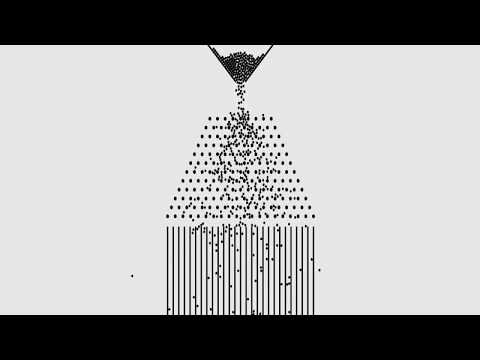

In [220]:
from IPython.display import YouTubeVideo

YouTubeVideo('AuEUAXlbE94', width=600, height=450)

In [256]:
def predict_many_step(positions, tree, array_indexes):
    have_children = tree.children_left[array_indexes] >= 0

    features = tree.feature[array_indexes]
    thresholds = tree.threshold[array_indexes]
    left_indexes = tree.children_left[array_indexes]
    right_indexes = tree.children_right[array_indexes]

    choosing_left = positions[np.arange(len(positions)), features] <= thresholds

    return np.where(have_children, np.where(choosing_left, left_indexes, right_indexes), array_indexes)

In [257]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

In [265]:
array_indexes = predict_many_step(positions, decision_tree.tree_, array_indexes)
array_indexes

array([ 3,  7, 12], dtype=int64)

In [266]:
def predict_many(positions, tree):
    array_indexes = np.zeros(len(positions), np.int64)

    for iteration in range(tree.max_depth):
        array_indexes = predict_many_step(positions, tree, array_indexes)
    
    leaf_decisions = np.argmax(decision_tree.tree_.value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

In [267]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many(positions, decision_tree.tree_)

array([1, 0, 1])

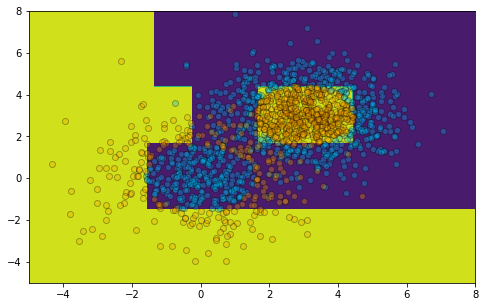

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [269]:
def predict_many_step_inplace(positions, tree, array_indexes):
    have_children = tree.children_left[array_indexes] >= 0

    features = tree.feature[array_indexes]
    thresholds = tree.threshold[array_indexes]
    left_indexes = tree.children_left[array_indexes]
    right_indexes = tree.children_right[array_indexes]

    array_indexes[have_children] = np.where(positions[np.arange(len(positions)), features] <= thresholds, left_indexes, right_indexes)[have_children]

In [270]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

In [271]:
predict_many_step_inplace(positions, decision_tree.tree_, array_indexes)
array_indexes

array([1, 1, 1])

In [251]:
def predict_many_inplace(positions, tree):
    array_indexes = np.zeros(len(positions), np.int64)

    for iteration in range(tree.max_depth):
        predict_many_step_inplace(positions, tree, array_indexes)
    
    leaf_decisions = np.argmax(decision_tree.tree_.value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

In [272]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many_inplace(positions, decision_tree.tree_)

array([1, 0, 1])

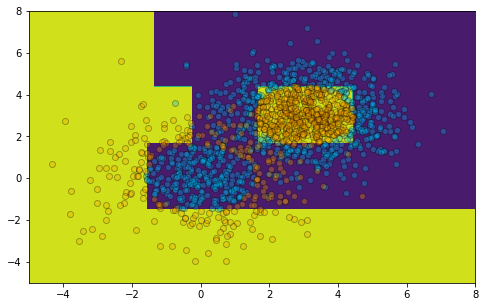

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_inplace(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [294]:
%%timeit

[predict_single(position, decision_tree.tree_) for position in np.c_[xx.ravel(), yy.ravel()]]

3.21 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [274]:
%%timeit

predict_many(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)

26.3 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [275]:
%%timeit

predict_many_inplace(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)

43.4 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [276]:
import numba as nb

In [288]:
@nb.njit
def predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, array_index=0):
    has_children = tree_children_left[array_index] >= 0

    if has_children:
        feature = tree_feature[array_index]
        threshold = tree_threshold[array_index]
        left_index = tree_children_left[array_index]
        right_index = tree_children_right[array_index]

        if position[feature] <= threshold:
            return predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, left_index)
        else:
            return predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, right_index)

    else:
        return np.argmax(tree_value[array_index])

In [289]:
predict_single_numba(
    np.array([-4, -4], np.float64),
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

1

In [290]:
@nb.njit
def predict_many_numba(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value):
    out = np.empty(len(positions), np.int64)
    for index, position in enumerate(positions):
        out[index] = predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value)
    return out

In [291]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many_numba(
    positions,
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

array([1, 0, 1])

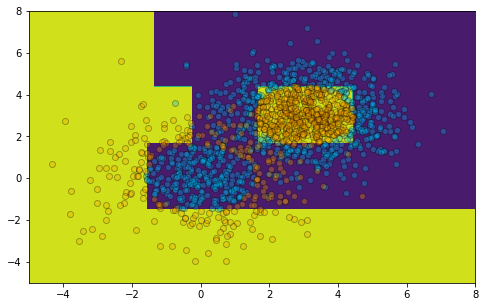

In [292]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_numba(
        np.c_[xx.ravel(), yy.ravel()],
        decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
    )
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [293]:
%%timeit

predict_many_numba(
    np.c_[xx.ravel(), yy.ravel()],
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

55.9 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [295]:
import jax

In [306]:
def predict_many_step_jax(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, array_indexes):
    have_children = tree_children_left[array_indexes] >= 0

    features = tree_feature[array_indexes]
    thresholds = tree_threshold[array_indexes]
    left_indexes = tree_children_left[array_indexes]
    right_indexes = tree_children_right[array_indexes]

    choosing_left = positions[jax.numpy.arange(len(positions)), features] <= thresholds

    return jax.numpy.where(have_children, jax.numpy.where(choosing_left, left_indexes, right_indexes), array_indexes)

def predict_many_jax(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value):
    array_indexes = jax.numpy.zeros(len(positions), np.int64)

    for iteration in range(decision_tree.tree_.max_depth):
        array_indexes = predict_many_step_jax(
            positions,
            tree_feature, tree_threshold, tree_children_left, tree_children_right, array_indexes,
        )
    
    leaf_decisions = jax.numpy.argmax(tree_value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

predict_many_jax = jax.jit(predict_many_jax, backend="cpu")

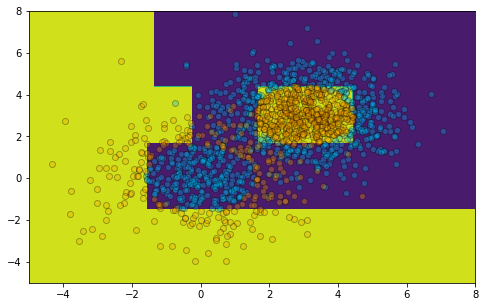

In [307]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_jax(
        np.c_[xx.ravel(), yy.ravel()],
        decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
    )
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [308]:
%%timeit

predict_many_jax(
    np.c_[xx.ravel(), yy.ravel()],
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

2.38 ms ± 82.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
